In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'seaborn-ticks'])

import numpy as np
import xarray as xr

from nowcast.nowcast import gaussian, multi_wave, hat

# Advection Equation

Given an initial tracer field and a constant background wind field, solve the two dimensional advection equation 

$$ \frac{\partial q}{\partial t} + \nabla\cdot(q\mathbf{u})= 0 $$

where $q$ is some scalar field and $\mathbf{u}$ is the velocity vector field, and $\nabla\cdot()$ is the divergence operator. For an incompressible flow such that

$$\nabla\cdot\mathbf{u} = 0$$

then the entire system simplifies to

$$ \frac{\partial q}{\partial t} + \mathbf{u}\cdot\nabla q = 0 $$

Furthermore, for a steady flow,

$$ \mathbf{u}\cdot\nabla q = 0 $$

which implies that $q$ is constant along a streamline, and that

$$\frac{\partial q}{\partial t} = 0$$

In general, this is a "hard" problem to solve numerically, since it forms a hyperbolic PDE. Instead of implementing an advection solver ourselves, we will instead defer to [ClawPack](http://www.clawpack.org/), which implements a suite of finite-volume solvers which should be suitable for this task (reference [2D advection solver](http://www.clawpack.org/pyclaw/gallery/advection_2d.html))

## `ClawPack` Testing

Exception ignored in: <bound method SharpClawSolver.__del__ of <clawpack.pyclaw.sharpclaw.solver.SharpClawSolver2D object at 0x12a303c88>>
Traceback (most recent call last):
  File "/Users/daniel/anaconda/envs/nowcast_test/lib/python3.6/site-packages/clawpack/pyclaw/sharpclaw/solver.py", line 274, in __del__
    self.fmod.clawparams.dealloc_clawparams()
AttributeError: 'NoneType' object has no attribute 'clawparams'


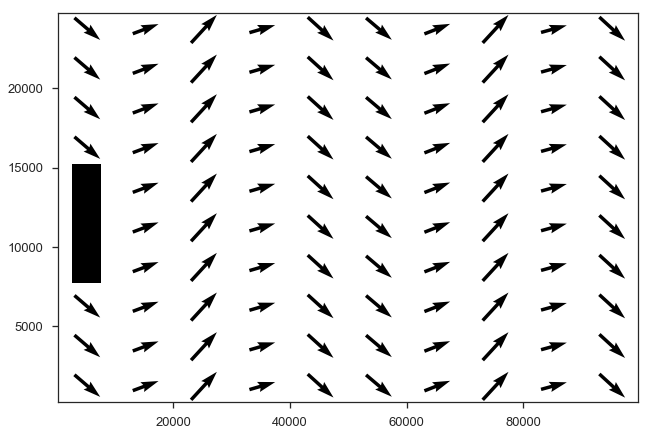

In [163]:
from clawpack import riemann
from clawpack import pyclaw

# rp = riemann.advection_2D
rp = riemann.vc_advection_2D
solver = pyclaw.SharpClawSolver2D(rp)
# solver = pyclaw.ClawSolver2D(rp)
# solver.limiters = pyclaw.limiters.tvd.vanleer
solver.bc_lower[0] = pyclaw.BC.extrap
solver.bc_upper[0] = pyclaw.BC.extrap
solver.bc_lower[1] = pyclaw.BC.extrap
solver.bc_upper[1] = pyclaw.BC.extrap

solver.aux_bc_lower[0] = pyclaw.BC.extrap
solver.aux_bc_upper[0] = pyclaw.BC.extrap
solver.aux_bc_lower[1] = pyclaw.BC.extrap
solver.aux_bc_upper[1] = pyclaw.BC.extrap

# Register domain
dx, dy = 500., 500.
nx, ny = 200, 50
x = pyclaw.Dimension(0, dx*nx, nx, name='x')
y = pyclaw.Dimension(0, dy*ny, ny, name='y')
domain = pyclaw.Domain([x, y])

x1d = domain.grid.x.centers
y1d = domain.grid.y.centers
xx = domain.grid.c_centers[0]
yy = domain.grid.c_centers[1]

num_eqn = 1
state = pyclaw.State(domain, num_eqn, num_aux=2)

# For non-vc
# state.problem_data['u'] = 10. # m/s
# state.problem_data['v'] = 1. # m/s

# For variable-coefficient
u = 20.*np.ones_like(yy)  # m/s
# u = 4.*multi_wave(xx, yy)
# v = 0.*np.ones_like(yy)  # m/s
v = -8.*np.cos(2.*np.pi*(1./(xx.max()/2.))*xx)
state.aux[0,...] = u
state.aux[1,...] = v

# q = gaussian(xx, yy, A=50., x0=10.*1000, y0=12.5*1000, sigmax=5.*1000., sigmay=7*1000)
# q[q < 20] = 0.0

q = hat(xx, yy, 50., [2500, 7500], [7500, 15000])

state.q[0,...] = q
plt.pcolormesh(xx, yy, q, vmin=0, vmax=50)
plt.quiver(xx[10::20,2::5], yy[10::20,2::5], u[10::20,2::5], v[10::20,2::5], 
           units='xy', angles='xy', scale_units='xy', pivot='middle')

In [164]:
claw = pyclaw.Controller()
claw.tfinal = 3600.
claw.solution = pyclaw.Solution(state, domain)
claw.solver = solver
claw.keep_copy = True

t_out = np.arange(0, 3601, 5*60)
claw.out_times = t_out
claw.num_output_times = len(t_out) - 1

In [165]:
claw.run()

2017-11-01 21:08:20,107 INFO CLAW: Solution 0 computed for time t=0.000000
2017-11-01 21:08:21,710 INFO CLAW: Solution 1 computed for time t=300.000000
2017-11-01 21:08:23,090 INFO CLAW: Solution 2 computed for time t=600.000000
2017-11-01 21:08:24,473 INFO CLAW: Solution 3 computed for time t=900.000000
2017-11-01 21:08:25,848 INFO CLAW: Solution 4 computed for time t=1200.000000
2017-11-01 21:08:27,228 INFO CLAW: Solution 5 computed for time t=1500.000000
2017-11-01 21:08:27,482 INFO CLAW: Solution 6 computed for time t=1800.000000
2017-11-01 21:08:27,959 INFO CLAW: Solution 7 computed for time t=2100.000000
2017-11-01 21:08:28,233 INFO CLAW: Solution 8 computed for time t=2400.000000
2017-11-01 21:08:28,764 INFO CLAW: Solution 9 computed for time t=2700.000000
2017-11-01 21:08:29,365 INFO CLAW: Solution 10 computed for time t=3000.000000
2017-11-01 21:08:29,898 INFO CLAW: Solution 11 computed for time t=3300.000000
2017-11-01 21:08:30,573 INFO CLAW: Solution 12 computed for time t=3

{'cflmax': 2.4500000000000006,
 'dtmax': 61.250000000000014,
 'dtmin': 61.249999999999993,
 'numsteps': 61}

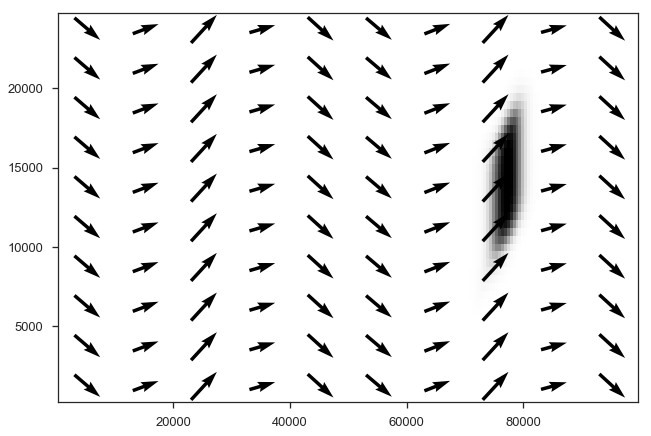

In [166]:
frames = claw.frames
plt.pcolormesh(xx, yy, frames[-1].q[0], vmin=0, vmax=50)
plt.quiver(xx[10::20,2::5], yy[10::20,2::5], u[10::20,2::5], v[10::20,2::5], 
           units='xy', angles='xy', scale_units='xy', pivot='middle')

In [7]:
times = claw.out_times
tracers = [f.q.squeeze() for f in claw.frames]
tracers = np.asarray(tracers)

ds = xr.Dataset(
    {'q': (('time', 'x', 'y'), tracers),
     'u': (('x', 'y'), u),
     'v': (('x', 'y'), v)},
    {'time': times, 'x': x1d, 'y': y1d},
)
ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
ds['y'].attrs.update({'long_name': 'y-coordinate', 'units': 'm'})
ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
ds['v'].attrs.update({'long_name': 'meridional wind', 'units': 'm/s'})
ds.attrs.update({
    'Conventions': 'CF-1.7'
})

ds.to_netcdf("test_cases/test_advection.nc")

NameError: name 'claw' is not defined

Note that in 1D with constant winds, the advection problem is dramatically simplified and analytically tractable, although we can always use numerical methods for simplicity:

$$\frac{\partial q}{\partial t} + u(x,t)\frac{\partial q}{\partial x} = 0$$

A simple test function $q(x, t)$ for which we can analytically solve this equation is the following time-shifting gaussian curve:

$$ q(x, t) = \exp\left( -\frac{(x - x_0) - ut}{L^2} \right) $$

where we've assumed a constant (in time and space) $u$.

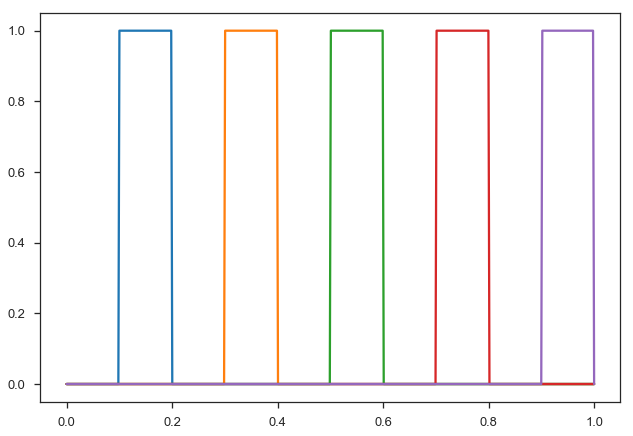

In [3]:
from functools import partial
from nowcast import gauss_1d, hat_1d

_g = partial(gauss_1d, x0=0.15, L=0.025, u=0.2, A=1)
_h = partial(hat_1d, x0=0.15, dx=0.05, u=0.2, A=1)

xs = np.linspace(0, 1, 500)
for i in range(5):
    ys = _h(xs, i)
    plt.plot(xs, ys, label=i)

Solve these same simulations using `ClawPack`

In [25]:
from functools import partial

from clawpack import riemann
from clawpack import pyclaw

import numpy as np
import xarray as xr

sharp = False
nx = 200
dx = 500

u = 10.
# qfunc = partial(gauss_1d, x0=15*1000, L=4*1000, u=u, A=1.)
qfunc = partial(hat_1d, x0=15*1000, dx=4*1000, u=u, A=1.)

rp = riemann.advection_1D
if sharp:
    solver = pyclaw.SharpClawSolver1D(rp)
    solver.weno_order = 5
else:
    solver = pyclaw.ClawSolver1D(rp)
    
solver.bc_lower[0] = pyclaw.BC.periodic
solver.bc_upper[0] = pyclaw.BC.periodic

x = pyclaw.Dimension(0, dx*nx, nx, name='x')
domain = pyclaw.Domain(x)

state = pyclaw.State(domain, solver.num_eqn)
state.problem_data['u'] = u

x1d = domain.grid.x.centers
q = qfunc(x1d, t=0)

state.q[0, ...] = q

In [26]:
claw = pyclaw.Controller()
claw.keep_copy = True
claw.solution = pyclaw.Solution(state, domain)
claw.solver = solver

t_out=np.arange(0, 3601, 5*60)
claw.tfinal = t_out[-1]
claw.out_times = t_out
claw.num_output_times = len(t_out) - 1

In [27]:
claw.run()

times = claw.out_times
tracers = [f.q.squeeze() for f in claw.frames]
tracers = np.asarray(tracers)

2017-11-02 10:48:28,061 INFO CLAW: Solution 0 computed for time t=0.000000
2017-11-02 10:48:28,067 INFO CLAW: Solution 1 computed for time t=300.000000
2017-11-02 10:48:28,076 INFO CLAW: Solution 2 computed for time t=600.000000
2017-11-02 10:48:28,084 INFO CLAW: Solution 3 computed for time t=900.000000
2017-11-02 10:48:28,093 INFO CLAW: Solution 4 computed for time t=1200.000000
2017-11-02 10:48:28,101 INFO CLAW: Solution 5 computed for time t=1500.000000
2017-11-02 10:48:28,110 INFO CLAW: Solution 6 computed for time t=1800.000000
2017-11-02 10:48:28,118 INFO CLAW: Solution 7 computed for time t=2100.000000
2017-11-02 10:48:28,130 INFO CLAW: Solution 8 computed for time t=2400.000000
2017-11-02 10:48:28,138 INFO CLAW: Solution 9 computed for time t=2700.000000
2017-11-02 10:48:28,146 INFO CLAW: Solution 10 computed for time t=3000.000000
2017-11-02 10:48:28,156 INFO CLAW: Solution 11 computed for time t=3300.000000
2017-11-02 10:48:28,164 INFO CLAW: Solution 12 computed for time t=3

In [28]:
uarr = u*np.ones_like(x1d)

ds = xr.Dataset(
    {'q': (('time', 'x'), tracers),
     'u': (('x', ), uarr)},
    {'time': times, 'x': x1d}
)
ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
ds.attrs.update({
    'Conventions': 'CF-1.7'
})

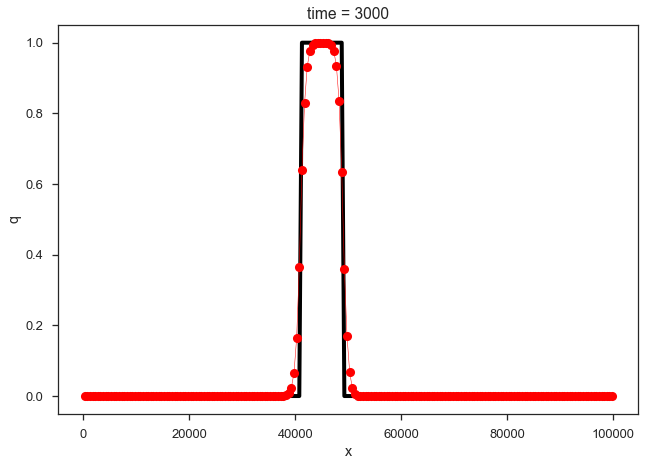

In [30]:
it = 10
t = float(ds.time.isel(time=it))
qref = qfunc(ds.x, t)


plt.plot(ds.x, qref, lw=4, color='k')
ds.q.isel(time=it).plot(lw=0.5, color='r', marker='o')

## 1D Cases

In [20]:
from nowcast.advection import advect_1d
from nowcast import hat_1d, gauss_1d

import numpy as np

nx = 400
dx = 500.

u = 10.
qfunc = partial(hat_1d, x0=15*1000, dx=4*1000, u=u, A=1.)

ds = advect_1d(10., qfunc, dict(t=0, x0=15*1000, dx=4*1000, u=u, A=1.),
               nx=nx, dx=dx, t_out=np.arange(0, 3601, 5*60), sharp=True)
ds['q_analytic'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
ds.to_netcdf("test_cases/hat_1d.nc")

ds = advect_1d(10., qfunc, dict(t=0, x0=15*1000, dx=4*1000, u=u, A=1.),
               nx=nx, dx=dx, t_out=np.arange(0, 7201, 5*60), sharp=True)
ds['q_analytic'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
ds.to_netcdf("test_cases/hat_1d.long.nc")

###

u = 10.
qfunc = partial(gauss_1d, x0=15*1000, L=4*1000, u=u, A=1.)

ds = advect_1d(10., qfunc, dict(t=0, x0=15*1000, L=4*1000, u=u, A=1.),
               nx=nx, dx=dx, t_out=np.arange(0, 3601, 5*60), sharp=True)
ds['q_analytic'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
ds.to_netcdf("test_cases/gauss_1d.nc")

ds = advect_1d(10., qfunc, dict(t=0, x0=15*1000, L=4*1000, u=u, A=1.),
               nx=nx, dx=dx, t_out=np.arange(0, 7201, 5*60), sharp=True)
ds['q_analytic'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
ds.to_netcdf("test_cases/gauss_1d.long.nc")

2017-11-02 17:55:33,070 INFO CLAW: Solution 0 computed for time t=0.000000
2017-11-02 17:55:33,079 INFO CLAW: Solution 1 computed for time t=300.000000
2017-11-02 17:55:33,087 INFO CLAW: Solution 2 computed for time t=600.000000
2017-11-02 17:55:33,096 INFO CLAW: Solution 3 computed for time t=900.000000
2017-11-02 17:55:33,111 INFO CLAW: Solution 4 computed for time t=1200.000000
2017-11-02 17:55:33,121 INFO CLAW: Solution 5 computed for time t=1500.000000
2017-11-02 17:55:33,134 INFO CLAW: Solution 6 computed for time t=1800.000000
2017-11-02 17:55:33,147 INFO CLAW: Solution 7 computed for time t=2100.000000
2017-11-02 17:55:33,157 INFO CLAW: Solution 8 computed for time t=2400.000000
2017-11-02 17:55:33,171 INFO CLAW: Solution 9 computed for time t=2700.000000
2017-11-02 17:55:33,181 INFO CLAW: Solution 10 computed for time t=3000.000000
2017-11-02 17:55:33,191 INFO CLAW: Solution 11 computed for time t=3300.000000
2017-11-02 17:55:33,205 INFO CLAW: Solution 12 computed for time t=3

## 1D - Additional

In [ ]:
u = 10.
qfunc = partial(gauss_1d, x0=15*1000, L=4*1000, u=u, A=1.)
# ds = xr.open_dataset("test_cases/gauss_1d.long.nc").copy()
# ds['q'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
# ds.to_netcdf("test_cases/gauss_1d.analytical.long.nc")

In [21]:
# u = 10.
# qfunc = partial(hat_1d, x0=15*1000, dx=4*1000, u=u, A=1.)
# ds = xr.open_dataset("test_cases/hat_1d.nc").copy()
# ds['q'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
# ds.to_netcdf("test_cases/hat_1d.analytical.nc")

# ds = xr.open_dataset("test_cases/hat_1d.long.nc").copy()
# ds['q'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
# ds.to_netcdf("test_cases/hat_1d.analytical.long.nc")


u = 10.
qfunc = partial(gauss_1d, x0=15*1000, L=4*1000, u=u, A=1.)
ds = xr.open_dataset("test_cases/gauss_1d.nc").copy()
ds['q'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
ds.to_netcdf("test_cases/gauss_1d.analytical.nc")

# ds = xr.open_dataset("test_cases/gauss_1d.long.nc").copy()
# ds['q'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
# ds.to_netcdf("test_cases/gauss_1d.analytical.long.nc")


## 2D Cases

In [12]:
from nowcast.advection import advect_field
from nowcast import hat, gaussian, min_gaussian

import numpy as np

MIN_VAL = 0.01

ds = advect_field(10., 0., 
                  hat, dict(A=1., xbnds=[2500, 7500], ybnds=[7500, 15000]),
                  t_out=np.arange(0, 3201, 5*60),
                  sharp=False)
ds = ds.where(ds > MIN_VAL)
ds.to_netcdf("test_cases/hat.linear.nc")

ds = advect_field(10., 0., 
                  hat, dict(A=1., xbnds=[2500, 7500], ybnds=[7500, 15000]),
                  t_out=np.arange(0, 7601, 5*60),
                  sharp=False)
ds = ds.where(ds > MIN_VAL)
ds.to_netcdf("test_cases/hat.linear.long.nc")

ds = advect_field(10., 0., 
                  min_gaussian, 
                  dict(minimum=MIN_VAL, A=1., x0=10.*1000, y0=12.5*1000, 
                       sigmax=1.75*1000., sigmay=3*1000),
                  t_out=np.arange(0, 3201, 5*60),
                  sharp=False)
ds = ds.where(ds > MIN_VAL)
ds.to_netcdf("test_cases/blob.linear.nc")

ds = advect_field(10., 0., 
                  min_gaussian, 
                  dict(minimum=MIN_VAL, A=1., x0=10.*1000, y0=12.5*1000, 
                       sigmax=1.75*1000., sigmay=3*1000),
                  t_out=np.arange(0, 7201, 5*60),
                  sharp=False)
ds = ds.where(ds > MIN_VAL)
ds.to_netcdf("test_cases/blob.linear.long.nc")

2017-11-01 21:50:36,445 INFO CLAW: Solution 0 computed for time t=0.000000
2017-11-01 21:50:36,474 INFO CLAW: Solution 1 computed for time t=300.000000
2017-11-01 21:50:36,503 INFO CLAW: Solution 2 computed for time t=600.000000
2017-11-01 21:50:36,533 INFO CLAW: Solution 3 computed for time t=900.000000
2017-11-01 21:50:36,563 INFO CLAW: Solution 4 computed for time t=1200.000000
2017-11-01 21:50:36,592 INFO CLAW: Solution 5 computed for time t=1500.000000
2017-11-01 21:50:36,629 INFO CLAW: Solution 6 computed for time t=1800.000000
2017-11-01 21:50:36,666 INFO CLAW: Solution 7 computed for time t=2100.000000
2017-11-01 21:50:36,702 INFO CLAW: Solution 8 computed for time t=2400.000000
2017-11-01 21:50:36,738 INFO CLAW: Solution 9 computed for time t=2700.000000
2017-11-01 21:50:36,770 INFO CLAW: Solution 10 computed for time t=3000.000000
(11, 200, 50) (200, 50) (200, 50) (200,)
2017-11-01 21:50:36,813 INFO CLAW: Solution 0 computed for time t=0.000000
2017-11-01 21:50:36,855 INFO CL

In [15]:
from clawpack import pyclaw

pyclaw.BC.periodic?